In [55]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [56]:
using Revise
using Turing
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [57]:
include("../VARs/utils.jl")
includet("../bootstrap_model.jl")

In [58]:
df = DataFrame(XLSX.readtable("../../data/usa_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.month, last)

872×12 TimeArray{Any, 2, Date, Matrix{Any}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬─────────┬────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E       │ CAPE  ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼─────────┼────────
│ 1951-12-01 │  0.02513 │   104.098 │       23.77 │  1.41333 │    2.44 │ 12.52 ⋯
│ 1952-01-01 │  0.02463 │   104.771 │       24.14 │  1.41667 │ 2.42667 │ 12.36 ⋯
│ 1952-02-01 │  0.02617 │   103.585 │       23.26 │     1.42 │ 2.41333 │ 12.36 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       24.37 │     1.43 │     2.4 │ 12.24 ⋯
│ 1952-04-01 │  0.02422 │   105.806 │       23.32 │     1.44 │    2.38 │ 12.20 ⋯
│ 1952-05-01 │  0.02384 │   106.373 │       23.86 │     1.45 │    2.36 │ 12.44 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       24.96 │     1.45 │    2.34 │ 12.66 ⋯
│ 1952-07-01 │  0.02466 │   106.034 │        25.4 │     1.45 │ 2.34667 │ 12.67 ⋯
│     ⋮      │    ⋮     │     ⋮     │   

In [59]:
freq = 12
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
start = Date(1955, 01,01)
end_d = Date(2024, 12, 31)


display("Returns")
display(returns_summarystats(to(from(returns, start),end_d), freq))
display("Real_returns")
display(returns_summarystats(to(from(real_returns, start),end_d), freq))


display("Correlations")
display(cor(values(to(from(real_returns, start),end_d)))) 

"Returns"

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1473,1.8543,0.1012,0.4365,-2.9008,-0.6469,-0.1883,0.0258,2.1941,0.6874,0.1474
Price_10Y,0.0755,1.3969,0.0531,0.1909,-0.9866,0.3097,-0.0893,0.1022,1.9867,0.7037,0.0377


nothing

"Real_returns"

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.1479,1.7607,0.0658,0.4053,-2.9112,-0.596,-0.2186,0.032,1.9119,0.445,0.1107
Price_10Y_CPI,0.078,1.279,0.0177,0.1544,-1.1677,0.2268,-0.1322,0.1437,2.0153,0.2268,0.0058


nothing

"Correlations"

2×2 Matrix{Float64}:
 1.0        0.0980477
 0.0980477  1.0

In [60]:
assets_names = [:Total_Stock_CPI, :Price_10Y_CPI]
data = to(from(real_returns[assets_names], start),end_d) 

835×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1955-01-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┐
│            │ Total_Stock_CPI │ Price_10Y_CPI │
├────────────┼─────────────────┼───────────────┤
│ 1955-01-01 │       0.0213695 │    -0.0101211 │
│ 1955-02-01 │      0.00706047 │   -0.00343316 │
│ 1955-03-01 │     -0.00133608 │    0.00336866 │
│ 1955-04-01 │       0.0403401 │   -0.00320268 │
│ 1955-05-01 │      0.00213171 │    0.00504353 │
│ 1955-06-01 │       0.0783234 │    -0.0123327 │
│ 1955-07-01 │       0.0618074 │    -0.0086779 │
│ 1955-08-01 │     -0.00842147 │   0.000622423 │
│     ⋮      │        ⋮        │       ⋮       │
│ 2024-01-01 │       0.0107954 │      -0.01189 │
│ 2024-02-01 │       0.0450847 │    -0.0241356 │
│ 2024-03-01 │       0.0277565 │     0.0036489 │
│ 2024-04-01 │      -0.0429306 │    -0.0372919 │
│ 2024-05-01 │       0.0476502 │     0.0176731 │
│ 2024-06-01 │       0.0349747 │     0.0154399 │
│ 2024-07-01 │       0.0122468 │     0.025

In [61]:
scenarios = overlapping_windows(values(data), 25*freq)

periods = [1,5, 10, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))
n_assets = length(assets_names)
for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, .025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  


,Total_Stock_CPI,Price_10Y_CPI
1,0.0728,0.021
5,0.0637,0.025
10,0.0589,0.0259
25,0.0608,0.0299


,Total_Stock_CPI,Price_10Y_CPI
1,0.1516,0.095
5,0.0699,0.0482
10,0.0515,0.0364
25,0.0205,0.0209


,Total_Stock_CPI,Price_10Y_CPI
1,-0.5848,0.6555
5,-0.0626,0.3998
10,-0.4354,0.0251
25,0.1304,-0.4484


,Total_Stock_CPI,Price_10Y_CPI
1,0.7655,0.9705
5,-0.5169,0.3175
10,-0.8852,-0.8823
25,-0.889,-0.5487


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.358,-0.2479,-0.1747,-0.0233,0.0827,0.1838,0.2895,0.3169,0.3559
5,-0.0843,-0.0632,-0.0501,0.0083,0.0738,0.108,0.188,0.2024,0.2129
10,-0.0445,-0.0371,-0.0302,0.0129,0.0695,0.0993,0.1342,0.1396,0.1429
25,0.0255,0.0272,0.0298,0.0418,0.0645,0.0722,0.0954,0.1,0.1041


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.1743,-0.1361,-0.1104,-0.0379,0.0142,0.078,0.2014,0.2781,0.2981
5,-0.0778,-0.0693,-0.0434,-0.0087,0.0196,0.0558,0.1019,0.1413,0.1578
10,-0.0477,-0.0437,-0.0261,-0.0052,0.0331,0.0534,0.0866,0.0929,0.0977
25,-0.0174,-0.0156,-0.0113,0.0135,0.0328,0.0444,0.0612,0.0629,0.0639


In [62]:
mdd, mddl = max_drawdown_and_length(scenarios[1,:,:])

display(assets_names[1])
display("mdd")
display(quantile(mdd, [.03, .25, .5, .75, .97])')
display("mddl")
display(quantile(mddl, [.03, .25, .5, .75, .97])')

mdd, mddl = max_drawdown_and_length(scenarios[2,:,:])

display(assets_names[2])
display("mdd")
display(quantile(mdd, [.03, .25, .5, .75, .97])')
display("mddl")
display(quantile(mddl, [.03, .25, .5, .75, .97])')

:Total_Stock_CPI

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.297485  0.51872  0.521378  0.539183  0.539183

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 35.05  98.75  145.0  153.0  153.0

:Price_10Y_CPI

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.12387  0.132702  0.397277  0.454945  0.468699

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 33.05  54.0  91.0  171.0  223.0

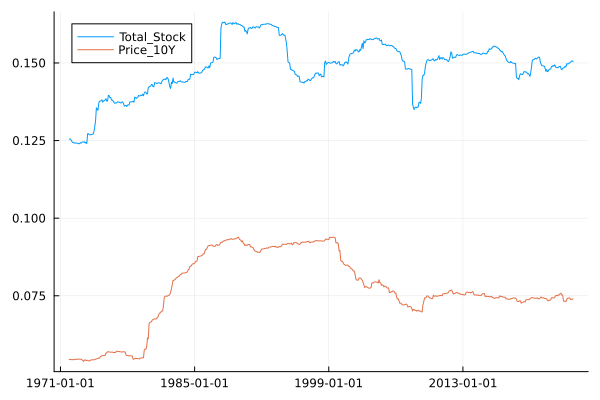

In [69]:
stds = moving(std, returns, 240) .* 12^0.5
plot(stds)